In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# For preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

import torch # For building the networks
import torchtuples as tt # Some useful functions

from pycox.models import LogisticHazard
from pycox.evaluation import EvalSurv
from pycox.preprocessing.feature_transforms import OrderedCategoricalLong

In [4]:
# We also set some seeds to make this reproducable.
np.random.seed(42)
_ = torch.manual_seed(42)

## Dataset

In [5]:
df_train_x = pd.read_csv('train_x.csv')
df_train_y = pd.read_csv('train_y.csv')
df_train_y['Status'].replace({True: 1, False: 0}, inplace=True)

In [6]:
df_test_x = pd.read_csv('test_x.csv')
df_test_y = pd.read_csv('test_y.csv')
df_test_y['Status'].replace({True: 1, False: 0}, inplace=True)

In [7]:
df_test = pd.concat([df_test_x, df_test_y], axis=1)
df_test = df_test.astype('float32')

In [8]:
df_train = pd.concat([df_train_x, df_train_y], axis=1)
df_train = df_train.astype('float32')

In [9]:
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

In [10]:
cols_standardize =  ['BE', 'BC', 'AQ', 'Age'] # Numerical columns
cols_leave = ['Y', 'AF', 'BG', 'BH', 'BI', 'BL',
              'BM', 'BP', 'CY', 'DC', 'DT',
              'DW', 'DX', 'DY', 'metastasis', 'secondprim'] # Binary columns
cols_categorical =  ['AY', 'DE'] # Categorical Columns

print(len(cols_standardize) + len(cols_leave) + len(cols_categorical))

22


In [11]:
# Turn them to binary features (0, 1)
df_train[cols_leave] -= 1
df_val[cols_leave] -= 1
df_test[cols_leave] -= 1

In [12]:
df_train.head(4)

,Y,AF,AQ,AY,BC,BE,BG,BH,BI,BL,...,DE,DT,DW,DX,DY,Age,metastasis,secondprim,Status,Survival
1,1.0,0.0,2.0,3.0,1.5,2.0,0.0,0.0,1.0,0.0,...,1.0,1.0,1.0,1.0,1.0,66.0,1.0,1.0,0.0,10000.0
2,1.0,0.0,3.0,3.0,2.9,3.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,48.0,1.0,1.0,0.0,12.0
4,1.0,1.0,2.0,3.0,3.5,3.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,1.0,75.0,1.0,1.0,1.0,347.0
6,0.0,0.0,2.0,2.0,2.6,2.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,1.0,0.0,47.0,1.0,1.0,1.0,989.0


In [13]:
# Preprocess different types of features.
standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]
categorical = [(col, OrderedCategoricalLong()) for col in cols_categorical]

x_mapper_float = DataFrameMapper(standardize + leave)
x_mapper_long = DataFrameMapper(categorical)  # we need a separate mapper to ensure the data type 'int64'

In [14]:
x_fit_transform = lambda df: tt.tuplefy(x_mapper_float.fit_transform(df), x_mapper_long.fit_transform(df))
x_transform = lambda df: tt.tuplefy(x_mapper_float.transform(df), x_mapper_long.transform(df))

In [15]:
x_train = x_fit_transform(df_train)
x_val = x_transform(df_val)
x_test = x_transform(df_test)

## Discretization

In [16]:
# Discretization
num_durations = 20
scheme = 'quantiles'
labtrans = LogisticHazard.label_transform(num_durations, scheme)

get_target = lambda df: (df['Survival'].values, df['Status'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))
durations_test, events_test = get_target(df_test)

In [17]:
labtrans.cuts

array([    0.,    51.,    96.,   114.,   155.,   206.,   230.,   288.,
         335.,   388.,   425.,   537.,   623.,   718.,   909.,  1112.,
        1359.,  1713.,  2048., 10000.], dtype=float32)

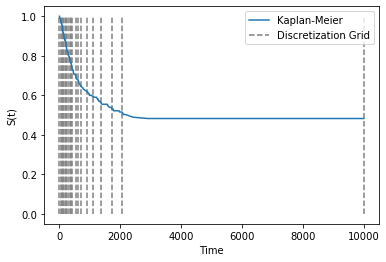

In [18]:
from pycox.utils import kaplan_meier
plt.vlines(labtrans.cuts, 0, 1, colors='gray', linestyles="--", label='Discretization Grid')
kaplan_meier(*get_target(df_train)).plot(label='Kaplan-Meier')
plt.ylabel('S(t)')
plt.legend()
_ = plt.xlabel('Time')

In [19]:
train = tt.tuplefy(x_train, y_train)
val = tt.tuplefy(x_val, y_val)


In [20]:
x_train.shapes()

((315, 20), (315, 2))

## Neural Network

In [21]:
num_embeddings = x_train[1].max(0) + 1
embedding_dims = num_embeddings // 2

In [22]:
num_embeddings, embedding_dims

(array([3, 4], dtype=int64), array([1, 2], dtype=int64))

In [23]:
in_features = x_train[0].shape[1]
out_features = labtrans.out_features
num_nodes = [32, 32, 32, 32]
batch_norm = True
dropout = 0.2

net = tt.practical.MixedInputMLP(in_features, num_embeddings, embedding_dims,
                                 num_nodes, out_features, batch_norm, dropout)

In [24]:
net

MixedInputMLP(
  (embeddings): EntityEmbeddings(
    (embeddings): ModuleList(
      (0): Embedding(3, 1)
      (1): Embedding(4, 2)
    )
  )
  (mlp): MLPVanilla(
    (net): Sequential(
      (0): DenseVanillaBlock(
        (linear): Linear(in_features=23, out_features=32, bias=True)
        (activation): ReLU()
        (batch_norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (1): DenseVanillaBlock(
        (linear): Linear(in_features=32, out_features=32, bias=True)
        (activation): ReLU()
        (batch_norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (2): DenseVanillaBlock(
        (linear): Linear(in_features=32, out_features=32, bias=True)
        (activation): ReLU()
        (batch_norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (

## Training the model

In [25]:
optimizer = tt.optim.AdamWR(decoupled_weight_decay=0.01, cycle_eta_multiplier=0.8,
                            cycle_multiplier=2)
model = LogisticHazard(net, optimizer, duration_index=labtrans.cuts)

c:\users\keivan\appdata\local\programs\python\python37\lib\site-packages\torchtuples\callbacks.py:607: UserWarning: This overload of add is deprecated:
	add(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add(Tensor other, *, Number alpha) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:1025.)
  p.data = p.data.add(-weight_decay * eta, p.data)


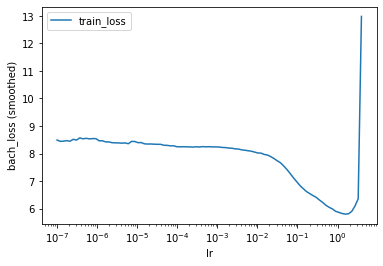

In [26]:
batch_size = 256
lrfind = model.lr_finder(x_train, y_train, batch_size, tolerance=50)
_ = lrfind.plot()

In [27]:
model.optimizer.param_groups[0]['lr']

0.15556761439304817

In [28]:
lrfind.get_best_lr()

0.15556761439304817

In [29]:
model.optimizer.set_lr(0.02)

In [30]:
epochs = 512
callbacks = [tt.cb.EarlyStoppingCycle()]
verbose = False

In [31]:
%%time
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val)

Wall time: 1.86 s


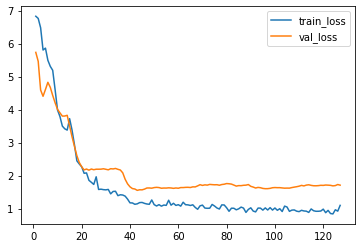

In [32]:
_ = log.to_pandas().iloc[1:].plot()

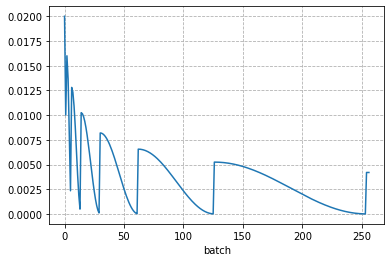

In [33]:
lrs = model.optimizer.lr_scheduler.to_pandas() * model.optimizer.param_groups[0]['initial_lr']
lrs.plot()
plt.grid(linestyle='--')

## Prediction

In [34]:
surv_cdi = model.interpolate(100).predict_surv_df(x_test)

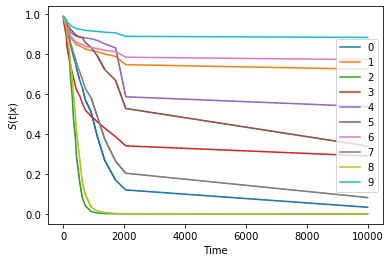

In [36]:
surv_cdi.iloc[:, :10].plot(drawstyle='steps-post')
plt.ylabel('$S(t|x)$')
_ = plt.xlabel('Time')

## Evaluation

In [43]:
ev_cdi = EvalSurv(surv_cdi, durations_test, events_test, censor_surv='km')

In [44]:
ev_cdi.concordance_td()#, ev_chi.concordance_td()

0.8495748855461086

In [45]:
durations_train, events_train = get_target(df_train)

In [46]:
surv_cdi_train = model.interpolate(100).predict_surv_df(x_train)

In [47]:
ev_cdi_train = EvalSurv(surv_cdi_train, durations_train, events_train, censor_surv='km')

In [48]:
ev_cdi_train.concordance_td()

0.9046076980014803

In [49]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev_cdi.integrated_brier_score(time_grid)#, ev_chi.integrated_brier_score(time_grid)

0.0734391628780089

In [50]:
time_grid = np.linspace(durations_train.min(), durations_train.max(), 100)
ev_cdi_train.integrated_brier_score(time_grid)#, ev_chi.integrated_brier_score(time_grid)

0.04679600690453481

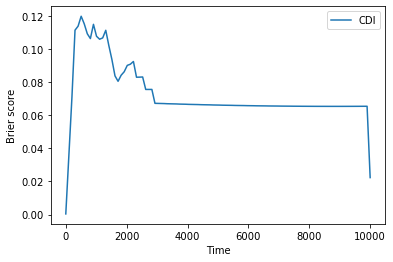

In [51]:
ev_cdi.brier_score(time_grid).rename('CDI').plot()
# ev_chi.brier_score(time_grid).rename('CHI').plot()
plt.legend()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')